# Sementic Modelling for Text-Image dataset : 
## Dataset :Flickr30k Dataset

### 1] Library Installation 

In [1]:
# Run below cell if library is not pre-intalled

#pip install pandas
#pip install matplotlib
#pip install Pillow

#pip install torch torchvision torchaudio
#pip install transformers


### 2] Import Library

In [2]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import models, transforms
from torch.nn.functional import cosine_similarity
from transformers import BertTokenizer, BertModel


### 3] Dataset Visulization

In [3]:
# Path to image and caption dataset
img_folder = 'E:/RIT/Sem 1/FA/Term Project/data/flickr30k_images'
caption_path = 'E:/RIT/Sem 1/FA/Term Project/data/results.csv' 

In [4]:
# Modifying the caption dataset(csv) inorder to process it
df_captions = pd.read_csv(caption_path, delimiter='|')
df_captions.columns = ['image_name', 'comment_number', 'comment']
df_captions['comment'] = df_captions['comment'].str.strip()

In [5]:
def data_visulization(img_folder, df_captions):
    # Creating the list all images
    img_list = [i for i in os.listdir(img_folder) if os.path.isfile(os.path.join(img_folder, i))]

    # Randomly selecting img
    img_name = random.choice(img_list)

    # Loading and display of the img
    img_path = os.path.join(img_folder, img_name)
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Retrieve and print the captions
    captions = df_captions[df_captions['image_name'] == img_name]['comment']
    for i, caption in enumerate(captions):
        print(f"Caption {i+1}: {caption}")


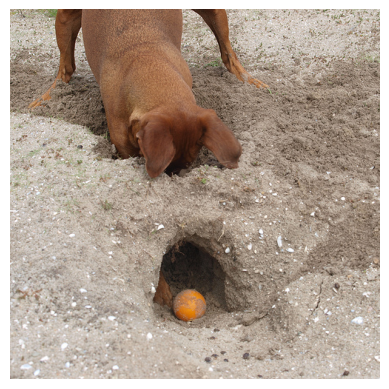

Caption 1: A brown dog is trying to retrive his orange ball that has fallen in a dirt hole .
Caption 2: A dog burrowing in the dirt trying to get an orange ball .
Caption 3: A brown dog digs in the sand for an orange ball .
Caption 4: A brown dog digging for a ball in the sand
Caption 5: A dog digging for his ball in the sand .


In [6]:
data_visulization(img_folder, df_captions)

### 4] Image Preprocessing

In [7]:
# Parameters specific to ResNet model
# Resize and cropping parameter
resize_scale = 256
crop_size = 224

# Normalization parameters
mean_values = [0.485, 0.456, 0.406]
std_devs = [0.229, 0.224, 0.225]

In [8]:
def img_preprocessing(image_path):
    # Transformating the img
    image_transformation = transforms.Compose([
        transforms.Resize(resize_scale),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_values, std=std_devs),])
    
    img = Image.open(image_path).convert('RGB')
    img_transformed = image_transformation(img)
    img_batch = img_transformed.unsqueeze(0)
    return img_batch


### 5] Text Preprocessing

In [9]:
# Calling required model for text preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
def text_preprocessing(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    return inputs

### 6] Image Feature Extraction

In [11]:
# Calling ResNet model for feature extraction from image
model_resnet = models.resnet50(pretrained=True)

C:\Users\Asus\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Modify the ResNet model to change the output size
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, 768)


In [13]:
def img_feature_extraction(tensor_image):
    # ResNet model in evalation model
    model_resnet.eval()
    with torch.no_grad():
        image_features = model_resnet(tensor_image)
    return image_features

### 7] Text Feature Extraction

In [14]:
# Calling BERT model feature extraction fromm text
model_bert = BertModel.from_pretrained('bert-base-uncased')


In [15]:
def text_feature_extraction(text_input):
    
    model_bert.eval()
    with torch.no_grad():
        text_outputs = model_bert(**text_input)
    #last_hidden_states = text_outputs.last_hidden_state
    text_embeddings = torch.mean(text_outputs.last_hidden_state, dim=1)
    return text_embeddings

### 8] Embedding Generation

In [16]:
# Final embedding of images and captions generation from the dataset
def final(image_folder, df_caption):
    image_features_list = []
    text_features_list = []
    
    img_subset = df_caption['image_name'].unique()[:10]  # taking subset of the commplete data
    
    #for image_name in annotations['image_name'].unique():
    for image_name in img_subset:

        image_path = os.path.join(image_folder, image_name)
        image_tensor = img_preprocessing(image_path)
        image_features = img_feature_extraction(image_tensor)
        
        image_features_list.append(image_features)

        # Print the captions
        captions = df_caption[df_caption['image_name'] == image_name]['comment']
        for i, caption in enumerate(captions):
            print(f"Caption {i+1}: {caption}")
            text_input = text_preprocessing(caption)
            text_features = text_feature_extraction(text_input)

            # Append features and corresponding caption features
            #image_features_list.append(image_features)
            text_features_list.append(text_features)
            print(len(text_features_list))

    return image_features_list, text_features_list




### 9] Similarity Calculation

In [17]:
def calculate_similarities(image_features, text_features):
    similarity_scores = []
    for image_feature in image_features:
        for text_feature in text_features:
            sim = cosine_similarity(image_feature, text_feature)
            #cosi = torch.nn.CosineSimilarity(dim=0) 
            #sim = cosi(image_feature, text_feature)

            similarity_scores.append(sim.item())
    return similarity_scores

In [18]:
image_features, text_features = final(img_folder, df_captions)

Caption 1: Two young guys with shaggy hair look at their hands while hanging out in the yard .
1
Caption 2: Two young , White males are outside near many bushes .
2
Caption 3: Two men in green shirts are standing in a yard .
3
Caption 4: A man in a blue shirt standing in a garden .
4
Caption 5: Two friends enjoy time spent together .
5
Caption 1: Several men in hard hats are operating a giant pulley system .
6
Caption 2: Workers look down from up above on a piece of equipment .
7
Caption 3: Two men working on a machine wearing hard hats .
8
Caption 4: Four men on top of a tall structure .
9
Caption 5: Three men on a large rig .
10
Caption 1: A child in a pink dress is climbing up a set of stairs in an entry way .
11
Caption 2: A little girl in a pink dress going into a wooden cabin .
12
Caption 3: A little girl climbing the stairs to her playhouse .
13
Caption 4: A little girl climbing into a wooden playhouse
14
Caption 5: A girl going into a wooden building .
15
Caption 1: Someone in 

In [19]:
similarity_scores = calculate_similarities(image_features, text_features )


In [20]:
len(similarity_scores)

500

In [21]:
# Function to calculate average of similarity score of each images with its corresponding 5 captions
def calculate_avg_similarity(data, size):
    result = []
    for start in range(0, len(data), size):
        end = start + size
        chunk = data[start:end]
        average = sum(chunk) / len(chunk)
        result.append(average)
    return result


In [22]:
averages = calculate_avg_similarity(similarity_scores, 5)


In [23]:
len(averages)

100

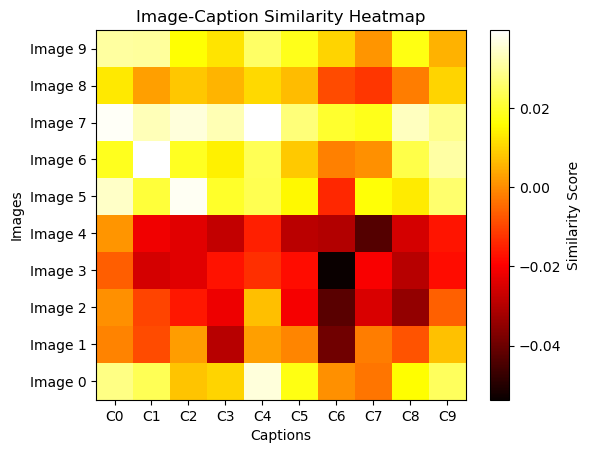

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# similarity scores
similarity_scores = averages 

# Reshape the scores into a 10x10 matrix
scores_matrix = np.reshape(similarity_scores, (10, 10))

# Plotting the heatmap
plt.imshow(scores_matrix, cmap='hot', interpolation='nearest')
plt.title("Image-Caption Similarity Heatmap")
plt.xlabel("Captions")
plt.ylabel("Images")
plt.colorbar(label='Similarity Score')
plt.gca().invert_yaxis()
plt.xticks(range(10), [f"C{i}" for i in range(10)])
plt.yticks(range(10), [f"Image {i}" for i in range(10)])
plt.show()
